Evaluating for layers = 1, neurons = 25...
Evaluating for layers = 1, neurons = 50...
Evaluating for layers = 1, neurons = 75...
Evaluating for layers = 2, neurons = 25...
Evaluating for layers = 2, neurons = 50...
Evaluating for layers = 2, neurons = 75...
Evaluating for layers = 3, neurons = 25...
Evaluating for layers = 3, neurons = 50...
Evaluating for layers = 3, neurons = 75...
Results saved to 'pinn_accuracy_vs_architecture.csv'


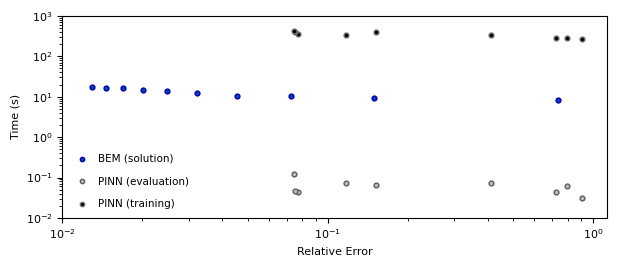

In [ ]:
 
%load_ext autoreload
%autoreload 2

# -*- coding: utf-8 -*-
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator


 

# Set the current directory and utilities path
current_dir =  os.getcwd()#os.path.dirname(os.path.abspath(__file__))


utilities_dir = os.path.join(current_dir, '../../utilities')

# Change the working directory to the notebook's directory
os.chdir(current_dir)

# Modify the module search path to include utilities directory
sys.path.insert(0, utilities_dir)

# Import the function to evaluate BEM accuracy
from bem_solution_functions import evaluate_bem_accuracy
from analytical_solution_functions import sound_hard_circle_calc 
from analytical_solution_functions import mask_displacement
from pinns_solution_functions import evaluate_pinn_accuracy 


#%%
r_i = np.pi/4 # Inner radius
l_se = np.pi # Outer semi-length
k = 3  # Wave number
n_grid = 501 # Number of grid points in x and y 

# List of n values to evaluate
n_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Create an empty list to store the results
results = []

# Evaluate for each value of n
for n in n_values:
    print(f"Evaluating for n = {n}...")
    t, err = evaluate_bem_accuracy(n=n)
    results.append({
        "n": n,
        "time_sec": t,
        "relative_error": err
    })

# Convert the results to a DataFrame
df = pd.DataFrame(results)

# Save the results to a CSV file
df.to_csv("data/bem_accuracy_vs_n.csv", index=False)

# Final message
print("Results saved to 'bem_accuracy_vs_n.csv'")
#%%

 
import pandas as pd

# Define the number of layers and neurons per layer to evaluate
layer_values = [1, 2, 3]
neuron_values = [25, 50, 75]

# List of training times in seconds (must match the order of layer-neuron combinations)
training_pinn_time = [
    268.5808, 287.7863, 291.1042,  # layers = 1
    333.6271, 346.1852, 356.2399,  # layers = 2
    401.7561, 396.7530, 430.8179   # layers = 3
]

# List to store the results
results = []

# Evaluate each combination of layers and neurons
i = 0
for layers in layer_values:
    for neurons in neuron_values:
        print(f"Evaluating for layers = {layers}, neurons = {neurons}...")
        eval_time, rel_error = evaluate_pinn_accuracy(layers, neurons, model_dir='models', k=3.0, r_i=np.pi/4, l_e=np.pi, n_grid=501)
        results.append({
            "layers": layers,
            "neurons_per_layer": neurons,
            "evaluation_time_sec": eval_time,
            "relative_error": rel_error,
            "training_time_sec": training_pinn_time[i]
        })
        i += 1

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Save results to CSV
df.to_csv("data/pinn_accuracy_vs_architecture.csv", index=False)

# Final message
print("Results saved to 'pinn_accuracy_vs_architecture.csv'")

#%%



# --- Load CSV data ---
bem_df = pd.read_csv("data/bem_accuracy_vs_n.csv")
pinn_df = pd.read_csv("data/pinn_accuracy_vs_architecture.csv")

# --- Marker sizes ---
pinn_marker_sizes = 12 #* pinn_df["layers"]  # PINN: scaled by number of layers
bem_marker_sizes = 12 #* bem_df["n"]          # BEM: scaled by number of integration points

# --- Plot setup ---
plt.figure(figsize=(6.0, 2.5))

# --- Plot BEM (blue) ---
plt.scatter(bem_df["relative_error"], bem_df["time_sec"],
            color="#0044c4", edgecolors="#0000a8",
            label='BEM (solution)', s=bem_marker_sizes, zorder=5)

# --- Plot PINN evaluation time (gray) ---
plt.scatter(pinn_df["relative_error"], pinn_df["evaluation_time_sec"],
            color="#bbbbbb", edgecolors="#5e5e5e",
            label='PINN (evaluation)', s=pinn_marker_sizes, zorder=4)

# --- Plot PINN training time (white with gray border) ---
plt.scatter(pinn_df["relative_error"], pinn_df["training_time_sec"],
            color="#000000", edgecolors="#6E6E6E",
            label='PINN (training)', s=pinn_marker_sizes, zorder=3)

# --- Axes labels ---
plt.xlabel('Relative Error', fontsize=8)
plt.ylabel('Time (s)', fontsize=8)

# --- Log-log scale ---
plt.xscale('log')
plt.yscale('log')

# --- Ticks ---
ax = plt.gca()
ax.set_xticks([1e+0, 1e-1, 1e-2])
ax.set_xticklabels([r'$10^{0}$', r'$10^{-1}$', r'$10^{-2}$'], fontsize=8)
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0, 2.0, 5.0), numticks=10))
ax.set_yticks([1e+3,1e+2,1e+1,1e+0, 1e-1, 1e-2])
ax.set_yticklabels([r'$10^{3}$', r'$10^{2}$', r'$10^{1}$', r'$10^{0}$', r'$10^{-1}$', r'$10^{-2}$'], fontsize=8)


# --- Legend ---
plt.legend(loc='lower left', fontsize=7.5, frameon=False,
           handletextpad=0.5, markerscale=0.9, labelspacing=1.2)

# --- Final layout and save ---
plt.tight_layout()
plt.savefig("figures/rel_error_time.svg", dpi=150, bbox_inches='tight')
plt.show()
